Goal: load gebco22 in sverdrup and write out bathymetry as **4 byte big endian float** data in a binary file. To be used in *data*:

```
 &PARM05
 ...
 bathyFile='descriptive-bathy-name.bin'
 ...
 &
```
GEBCO spans [-180,180] degE

In [2]:
import xarray as xr
import xmitgcm
import numpy as np
import xesmf as xe

# vis
import cmocean.cm as cm
import matplotlib.pyplot as plt

In [3]:
ncGEBCO='/scratch2/shared/gebco22/GEBCO_2022_sub_ice_topo.nc'
gebco = xr.open_dataset(ncGEBCO)

In [4]:
display(gebco)

<xarray.Dataset>
Dimensions:    (lon: 86400, lat: 43200)
Coordinates:
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat        (lat) float64 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 90.0
Data variables:
    crs        |S1 ...
    elevation  (lat, lon) int16 ...
Attributes: (12/36)
    title:                           The GEBCO_2022 Grid - a continuous terra...
    summary:                         The GEBCO_2022 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    references:                      DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    node_offset:                     1.0

#### The baroclinic gyre lat lon span covers mostly land

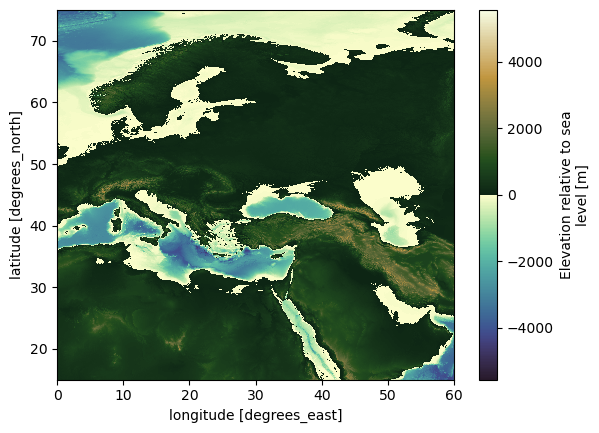

In [4]:
gebco.elevation.sel(lat=slice(15,75), lon=slice(0,60)).plot(cmap=cm.topo)

I'm going to shift westward to capture a basin to be used as bathymetry in the `baroclinic_gyre` model set-up

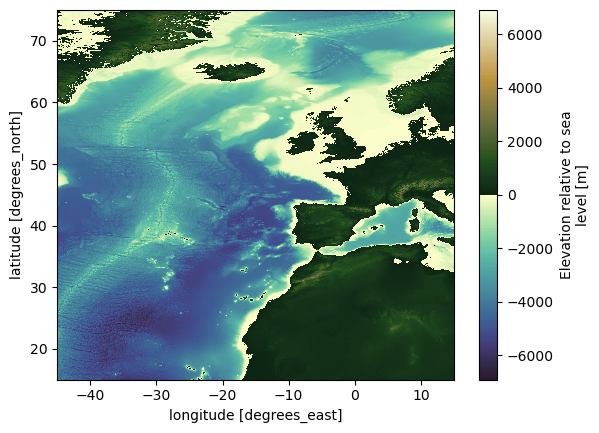

In [5]:
gebco.elevation.sel(lat=slice(15,75), lon=slice(-45,15)).plot(cmap=cm.topo)

load MITgcm grid you want to use into an xarray.DataSet

start with XC and YC from baroclinic gyre run: `~/ivana/regionalgcm/baroclinic_gyre`

In [6]:
xc = xmitgcm.utils.read_raw_data('/home/ivana/regionalgcm/baroclinic_gyre/run/XC.data',
                                 shape = (62,62), 
                                 dtype = np.dtype('>f4'),
                                )
# shift westward
xc = xc - 45
yc = xmitgcm.utils.read_raw_data('/home/ivana/regionalgcm/baroclinic_gyre/run/YC.data',
                                 shape = (62,62), 
                                 dtype = np.dtype('>f4'),
                                )

x = xr.DataArray(np.array(xc, dtype='float32'), 
                 dims=('j','i'), 
                 coords={'j': np.arange(xc.shape[0]),
                         'i': np.arange(xc.shape[1]),},
                 attrs={'standard_name':'longitude'}
                         )
y = xr.DataArray(np.array(yc, dtype='float32'), 
                 dims=('j','i'), 
                 coords={'j': np.arange(yc.shape[0]),
                         'i': np.arange(yc.shape[1]),},
                 attrs={'standard_name':'latitude'}
                         )
gcmGrid = xr.Dataset({'lon': x, 'lat': y})

In [7]:
gcmGrid

<xarray.Dataset>
Dimensions:  (j: 62, i: 62)
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 52 53 54 55 56 57 58 59 60 61
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 52 53 54 55 56 57 58 59 60 61
Data variables:
    lon      (j, i) float32 -45.5 -44.5 -43.5 -42.5 ... 12.5 13.5 14.5 15.5
    lat      (j, i) float32 14.5 14.5 14.5 14.5 14.5 ... 75.5 75.5 75.5 75.5

### Downsample GEBCO to gcm grid
Next cell takes a loooong time, even with `dask` chunks

In [8]:
regridder = xe.Regridder(gebco.sel(lat=slice(14,76), lon=slice(-46,16)), 
                         gcmGrid, 
                         'nearest_s2d')

In [17]:
gebcoOut = regridder( gebco.elevation.sel(lat=slice(14,76), 
                                          lon=slice(-46,16)) )

write xr.DataArray `gebcoOut` to a binary file

In [11]:
gcmGrid['Depth'] = gebcoOut
gcm = gcmGrid#.set_coords(['lon','lat'])
gcm = gcm.assign_coords(j=gcm.lat.sel(i=0), i=gcm.lon.sel(j=0))

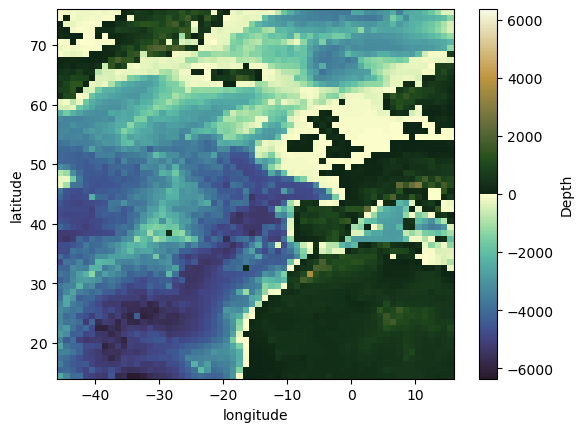

In [12]:
gcm.Depth.plot(cmap=cm.topo)

#### Plot shifted to work with baroclinic gyre

In [5]:
import sandbox as sb
nLine = 6
line = sb.wgs84space([2.6,60.1], [20.7,40.2], nLine)

In [14]:
# vis adjustments to look like baroclinic gyre
gcm['lon'] = gcm.lon + 45
gcm['i'] = gcm.lon.isel(j=0)
gcm['i'].attrs['standard_name'] = 'longitude'

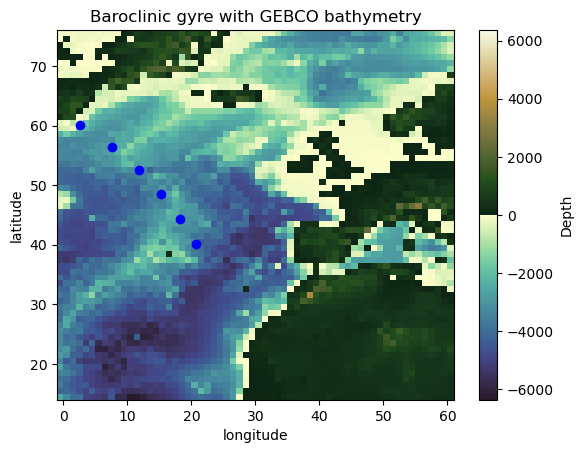

In [15]:
gcm.Depth.plot(cmap=cm.topo)
plt.scatter(line.lons, line.lats, 
            color='blue', zorder=3)
plt.title('Baroclinic gyre with GEBCO bathymetry')
plt.savefig('/home/ivana/regionalgcm/img/bcgyre_gebco-bathy_generic-ihop-path.png', bbox_inches='tight', transparent=True)

In [30]:
# set edges to 0 
gebcoOut = gebcoOut.where(~gebcoOut['i'].isin([0,61]), 0)
gebcoOut = gebcoOut.where(~gebcoOut['j'].isin([0,61]), 0)

<xarray.DataArray (i: 62)>
array([    0, -4056, -4278, -4664, -4926, -4369, -4914, -5092, -4674,
       -5024, -5476, -5546, -5526, -5367, -5162, -5304, -5191, -5113,
       -4922, -4567, -4262, -3910, -2131, -2951, -3979, -3793, -3529,
       -3039, -1451,    46,    29,    49,    77,    41,    83,   172,
         213,   262,   284,   319,   270,   265,   264,   296,   323,
         284,   279,   308,   282,   283,   355,   568,   465,   470,
         496,   454,   431,   397,   343,   362,   368,     0],
      dtype=int16)
Coordinates:
    j        int64 1
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 52 53 54 55 56 57 58 59 60 61
Attributes:
    regrid_method:  nearest_s2d

In [34]:
# Convert DataArray values to big endian
gebcoOut = gebcoOut.values.astype('>f4')
gebcoOut.tofile('/home/ivana/regionalgcm/data/gebco_bcgyre.bin')

### ihop bathy
Depths at ihop range points:
 - make finer bathymetry line from source to receiver
 - write out bathy to a baro.bty file after regridding

In [6]:
shift=-45
bathyline = sb.wgs84space([2.6+shift,60.1], [20.7+shift,40.2], 50)
gebcomini=gebco.sel(lon=slice(2.6+shift-1,20.7+shift+1), lat=slice(40.2-1, 60.1+1))

<xarray.DataArray 'elevation' (lat: 50, lon: 50)>
array([[ -225, -1641, -2040, ..., -2270, -2291, -2198],
       [ -540, -1835, -2105, ..., -2257, -2465, -2445],
       [-1911, -2181, -2467, ..., -2556, -2563, -2659],
       ...,
       [-4971, -4967, -4764, ..., -3611, -3788, -3504],
       [-4968, -4999, -5015, ..., -3469, -3451, -3772],
       [-4905, -5022, -4993, ..., -3373, -3470, -3608]], dtype=int16)
Coordinates:
  * lon      (lon) float64 -42.4 -41.84 -41.28 -40.74 ... -24.79 -24.54 -24.3
  * lat      (lat) float64 60.1 59.73 59.36 58.98 ... 41.49 41.06 40.63 40.2
Attributes:
    standard_name:       height_above_mean_sea_level
    long_name:           Elevation relative to sea level
    units:               m
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

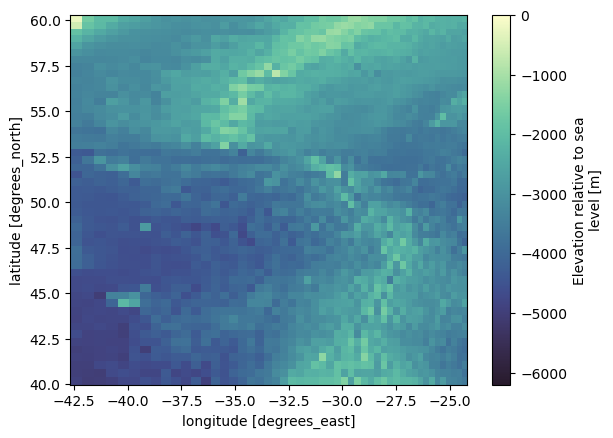

In [43]:
bathyihop = gebcomini['elevation'].sel(lon=bathyline.lons, lat=bathyline.lats, method='nearest')
display(bathyihop)

bathyihop.plot(cmap=cm.deep_r, vmax=0, vmin=-6200)
plt.scatter(line.lons, line.lats, 
            color='blue', zorder=3)
plt.title('Baroclinic gyre with GEBCO bathymetry')

In [56]:
depths=[]; ranges=[]
for i in range(len(bathyline.lons)):
    ranges.append( bathyline.del_s*i/1000. )
    depths.append( -1*bathyihop.sel(lon=bathyline.lons[i],
                                    lat=bathyline.lats[i], 
                                    method='nearest').values )
    print(f"{ranges[i]:.4f}\t{depths[i]}")

0.0000	225
51.9299	1835
103.8597	2467
155.7896	2933
207.7195	3127
259.6493	3203
311.5792	3320
363.5091	2989
415.4389	2687
467.3688	2617
519.2987	2683
571.2285	2548
623.1584	2245
675.0883	2461
727.0181	1778
778.9480	2485
830.8779	1840
882.8077	1848
934.7376	2903
986.6675	3291
1038.5973	3636
1090.5272	3031
1142.4571	3425
1194.3869	3190
1246.3168	3497
1298.2467	3564
1350.1765	3087
1402.1064	3563
1454.0362	3613
1505.9661	3631
1557.8960	2909
1609.8258	3012
1661.7557	3002
1713.6856	3099
1765.6154	3304
1817.5453	2262
1869.4752	3557
1921.4050	2825
1973.3349	2720
2025.2648	2777
2077.1946	2681
2129.1245	2792
2181.0544	3190
2232.9842	3180
2284.9141	3252
2336.8440	3709
2388.7738	3277
2440.7037	3611
2492.6336	3451
2544.5634	3608


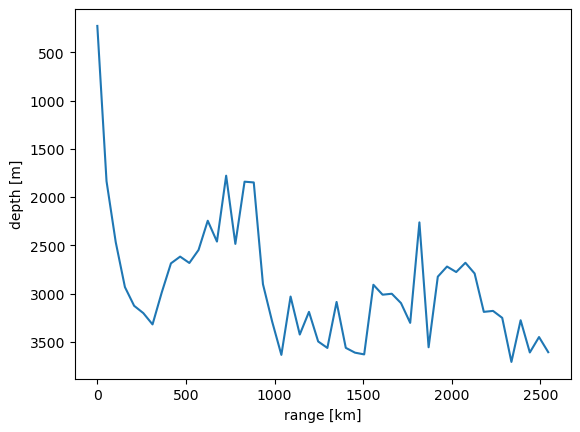

In [61]:
plt.plot(ranges,depths)
plt.gca().invert_yaxis()
plt.ylabel('depth [m]')
plt.xlabel('range [km]')
plt.show()

<sub> Written by Escobar, I on October 2023 </sub>